In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import math
from gurobipy import Model, GRB, quicksum, abs_

In [24]:
n = 14
D = 3
vT = 10
vD = 15

bound_length = 1000

dRs = np.random.uniform(low = 0.0, high = np.sqrt(2)*0.8*bound_length, size = n//2)
tRs = (dRs/vD).tolist()

xc = np.random.randint(low=0,high=bound_length,size=n+1)
#xc = np.linspace(0, np.sqrt(2)*bound_length, n+2, dtype = 'int32').tolist()
#xc.pop(-1)
yc = xc

xc[0] = 0
yc[0] = 0

#plt.plot(xc[0], yc[0], c='r', marker='s')
#plt.scatter(xc[1:], yc[1:], c='b')

#sets needed
V = [i for i in range(1, n+1)]
eV = [i for i in V if i % 2 == 0]
oV = [i for i in V if i % 2 == 1]
N = [0] + V
A = [(i, j) for i in N for j in N if i != j]
R = [i for i in range(1,(n//2) + 1)]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j])/vT for i, j in A}
tR = {i: tRs[i-1] for i in R}

#computed values for better variable bounds
M = (np.sqrt(2)*bound_length*2)
costs = list(c.values())
cmax = max(costs)
maxdiff = 0
for i in N:
    for j in N:
        diff = costs[i] - costs[j]
        if diff > maxdiff:
            maxdiff = diff

mdl = Model('Truck Problem')

In [25]:
#variables needed, most are intermediate helpers lol
x = mdl.addVars(A, vtype=GRB.BINARY, name = "x")
a = mdl.addVars(N, ub = (n+1)*cmax, vtype=GRB.CONTINUOUS, name = "a")
b = mdl.addVars(R, lb = -1*maxdiff, ub = maxdiff, vtype=GRB.CONTINUOUS, name = "b")
z = mdl.addVars(R, ub = maxdiff, vtype=GRB.CONTINUOUS, name = "z")
d = mdl.addVars(R, ub = max(maxdiff,max(tRs)), vtype=GRB.CONTINUOUS, name = "d")
e = mdl.addVars(R, vtype=GRB.BINARY, name = "e")
f = mdl.addVars(V, lb = -1, ub = 1, vtype=GRB.INTEGER, name = "f")
g = mdl.addVars(V, vtype=GRB.BINARY, name = "g")
y = mdl.addVars(N, lb = 0, ub = 1*D, vtype=GRB.INTEGER, name = "y")

mdl.modelSense = GRB.MINIMIZE

In [26]:
#objective is sum of truck time costs plus truck waiting times
mdl.setObjective(
    quicksum(x[i, j]*c[i, j] for i, j in A) + 
    quicksum(tR[i] - d[i] for i in R))

#sum of x[i,j]'s  for all fixed values of i is 1 (exactly one outgoing edge from every node)
mdl.addConstrs(quicksum(x[i, j] for j in N if j != i) == 1 for i in N)

#sum of x[i,j]'s  for all fixed values of j is 1 (exactly one incoming edge from every node)
mdl.addConstrs(quicksum(x[i, j] for i in N if i != j) == 1 for j in N)

#set arrival time at node 0 to be 0
a[0].ub = 0.0

#if edge (i,j) is in solution, then a[j] = a[i] + c[i,j]
#also functions as Miller-Tucker-Zemlin constraint since it prevents subcycles
mdl.addConstrs((x[i, j] == 1) >> (a[i]+c[i,j] == a[j]) for i, j in A if j != 0)

#b[i] = a[2i] - a[2i-1] (truck travel time between route endpoints), is a helper
mdl.addConstrs(b[i] == a[2*i] - a[(2*i)-1] for i in R)

#z[i] = |b[i]|, is another helper variable
for i in R:
    mdl.addGenConstrAbs(z[i],b[i])

#if e[i] = 1 then d[i] = z[i], both d[i] and e[i] are helpers
mdl.addConstrs((e[i] == 1) >> (d[i] == z[i]) for i in R)
#if e[i] = 1 then d[i] = tR[i], d[i] is used in the objective
mdl.addConstrs((e[i] == 0) >> (d[i] == tR[i]) for i in R)

#if z[i] <= tR[i] then e[i] = 1
#mdl.addConstrs(tR[i] - z[i] <= max(tR)*e[i] for i in R)
#if e[i] = 1 then z[i] <= tR[i], completes the iff statement
mdl.addConstrs((e[i] == 1) >> (z[i] <= tR[i]) for i in R)
mdl.addConstrs((e[i] == 0) >> (z[i] >= tR[i]) for i in R)

#if a[j] < a[j-1] then g[j] = 1, otherwise g[j] = 0 for even j
#g[j] = 1 means starting new route, otherwise completing route
#mdl.addConstrs(a[j-1] - a[j] <= maxdiff*g[j] for j in eV)
mdl.addConstrs((g[j] == 1) >> (a[j] <= a[j-1]) for j in eV)
mdl.addConstrs((g[j] == 0) >> (a[j] >= a[j-1]) for j in eV)

#if a[j] > a[j-1] then h[j] = 1, otherwise g[j] = 0 for odd j
#g[j] = 1 means starting new route, otherwise completing route
#mdl.addConstrs(a[j+1] - a[j] <= maxdiff*g[j] for j in oV)
mdl.addConstrs((g[j] == 1) >> (a[j] <= a[j+1]) for j in oV)
mdl.addConstrs((g[j] == 0) >> (a[j] >= a[j+1]) for j in oV)

#if g[j] = 1, then f[j] = -1 since we are starting a new route, so capacity decreases
mdl.addConstrs((g[j] == 1) >> (f[j] == -1) for j in V)
#if g[j] = 0, then f[j] = 1 since we are completing old route, so capacity increases
mdl.addConstrs((g[j] == 0) >> (f[j] == 1) for j in V)

#if edge (i,j) is in solution, then capacity y[j] = y[i] + f[j]
mdl.addConstrs((x[i, j] == 1) >> (y[i]+f[j] == y[j]) for i, j in A if j != 0)

#0 <= y[j] <= D (# of drones) for all j
mdl.addConstrs(y[j] >= 0 for j in V)
mdl.addConstrs(y[j] <= D for j in V)

#set drone availability at node 0 (depot) to be D
y[0].lb = D
y[0].ub = D

mdl.Params.MIPGap = 0.05
mdl.Params.TimeLimit = 60  # seconds

Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [ ]:
mdl.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 65 rows, 296 columns and 469 nonzeros
Model fingerprint: 0x7d8b76d2
Model has 483 general constraints
Variable types: 36 continuous, 260 integer (231 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 3e+00]
Presolve added 651 rows and 180 columns
Presolve time: 0.02s
Presolved: 716 rows, 476 columns, 3451 nonzeros
Presolved model has 182 SOS constraint(s)
Variable types: 224 continuous, 252 integer (238 binary)

Root relaxation: objective 1.230366e+02, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  123.03658    0   24          -  123.03658      -     -    0s
     0     0  123.03658    0   53          -  123.03658      -     -    0s
     0     0  123.03658  


VARIABLE MEANINGS:
x[i,j] is presence of edge in solution
a[i] is arrival time at node i
b[i] is signed truck travel time between endpoints of route i
z[i] is absolute truck travel time between endpoints of route i
e[i] is 1 if truck travel time z[i] on route i is less than drone travel time on route i, 0 otherwise
d[i] equals z[i] if e[i] is 1, tR[i] otherwise
f[i] equals -1 if starting new route at node i, 1 if completing old route at node i
g[i] equals 1 if truck arrives at node i before other endpoint of route, 0 otherwise.
y[i] is the number of available vehicles after node i
--------

coords: 0 528 463 866 889 137 380 193 214 512 660 649 940 907 641 530 134 270 362 

drone route times: {1: 70.31706106919412, 2: 71.53600555556277, 3: 66.13538758844822, 4: 67.59429171346554, 5: 41.87004748481843, 6: 55.85416874629986, 7: 69.38992918447737, 8: 4.758155024405629, 9: 49.1191025936677} 

a[0] 0
a[1] 167.726
a[2] 65.4781
a[3] 215.526
a[4] 296.843
a[5] 19.3747
a[6] 53.7401
a[7] 103.662


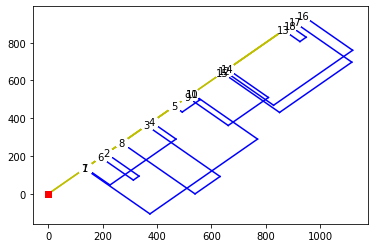

In [9]:
print("\nVARIABLE MEANINGS:")
print("x[i,j] is presence of edge in solution")
print("a[i] is arrival time at node i")
print("b[i] is signed truck travel time between endpoints of route i")
print("z[i] is absolute truck travel time between endpoints of route i")
print("e[i] is 1 if truck travel time z[i] on route i is less than drone travel time on route i, 0 otherwise")
print("d[i] equals z[i] if e[i] is 1, tR[i] otherwise")
print("f[i] equals -1 if starting new route at node i, 1 if completing old route at node i")
print("g[i] equals 1 if truck arrives at node i before other endpoint of route, 0 otherwise.")
print("y[i] is the number of available vehicles after node i")

print("--------\n")
print("coords:", *xc, "\n")
print("drone route times:", tR, "\n")
#print(c)

for v in mdl.getVars():
    if(not("x" in v.varName)):
        print('%s %g' % (v.varName, v.x))

active_arcs = [a for a in A if x[a].x > 0.98]

active_arcs = sorted(active_arcs, key=lambda x: x[0])

print(active_arcs)

visit_order = []
route = "0 -> "
i = 0
curr = 0
while i < n:
    curr = active_arcs[curr][1]
    if(curr != 0):
        visit_order.append(curr)
    route = route + str(curr) + " -> "
    i += 1
route = route + "0"

print(route)

for i in R:
    e1 = xc[(2*i)-1]
    e2 = xc[(2*i)]
    c1x = e1 + (30*i)
    c1y = e1 - (30*i)
    c2x = e2 + (30*i)
    c2y = e2 - (30*i)
    plt.plot([e1, c1x], [e1, c1y], c='b', zorder=0)
    plt.plot([c1x, c2x], [c1y, c2y], c='b', zorder=0)
    plt.plot([c2x, e2], [c2y, e2], c='b', zorder=0)

for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='y', zorder=0)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c = 'w', linewidth = 7)

for i in range(len(visit_order)):
    dex = visit_order[i]
    plt.text(xc[dex],yc[dex],i+1, ha="center", va="center")

<module 'matplotlib.pyplot' from '/Users/saaketh/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/pyplot.py'>